In [ ]:

S#!pip install tensorflow Pillow numpy matplotlib

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os
import hashlib
from PIL import Image
import numpy as np
import pandas as pd

In [ ]:
# Directory paths
base_dir = '/content/drive/MyDrive/projects/BoneFracture/dataset'
train_dir = base_dir + '/train'
val_dir = base_dir + '/val'
test_dir = base_dir + '/test'

#EXTRACTING IMAGES into DataFrames

In [ ]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [ ]:
train = data(train_dir)
val = data(val_dir)
test = data(test_dir)


In [ ]:
val

,image,label
0,/content/drive/MyDrive/projects/BoneFracture/d...,fractured
1,/content/drive/MyDrive/projects/BoneFracture/d...,fractured
2,/content/drive/MyDrive/projects/BoneFracture/d...,fractured
3,/content/drive/MyDrive/projects/BoneFracture/d...,fractured
4,/content/drive/MyDrive/projects/BoneFracture/d...,fractured
...,...,...
399,/content/drive/MyDrive/projects/BoneFracture/d...,not fractured
400,/content/drive/MyDrive/projects/BoneFracture/d...,not fractured
401,/content/drive/MyDrive/projects/BoneFracture/d...,not fractured
402,/content/drive/MyDrive/projects/BoneFracture/d...,not fractured


#DATA COUNT AND VISUALIZATION

In [ ]:
# prompt: distribution of the classes

import os

def count_classes(directory):
  class_counts = {}
  for class_name in os.listdir(directory):
    class_path = os.path.join(directory, class_name)
    if os.path.isdir(class_path):
      class_counts[class_name] = len(os.listdir(class_path))
  return class_counts

train_counts = count_classes(train_dir)
val_counts = count_classes(val_dir)
test_counts = count_classes(test_dir)

print("Training set distribution:", train_counts)
print("Validation set distribution:", val_counts)
print("Test set distribution:", test_counts)

Training set distribution: {'not fractured': 2020, 'fractured': 2079}
Validation set distribution: {'fractured': 169, 'not fractured': 237}
Test set distribution: {'fractured': 200, 'not fractured': 201}


Image Distribution

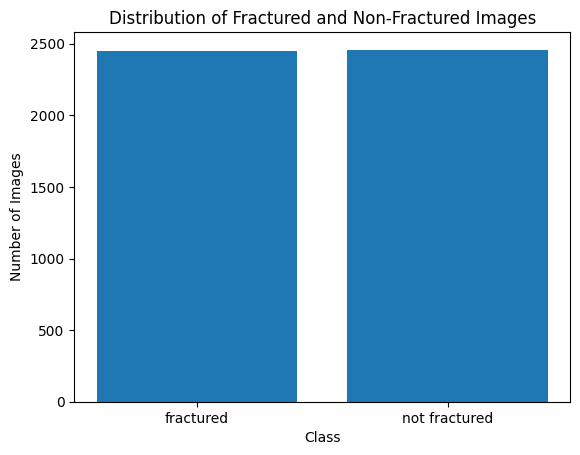

fractured: 2448 images
not fractured: 2458 images


In [ ]:
# prompt: distribution of fractured and non fractured and visualize

import matplotlib.pyplot as plt

# Combine counts from all sets
all_counts = {'fractured': train_counts.get('fractured', 0) + val_counts.get('fractured', 0) + test_counts.get('fractured', 0),
              'not fractured': train_counts.get('not fractured', 0) + val_counts.get('not fractured', 0) + test_counts.get('not fractured', 0)}

# Plot the distribution
plt.bar(all_counts.keys(), all_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Fractured and Non-Fractured Images')
plt.show()

# Print the exact numbers
for class_name, count in all_counts.items():
    print(f"{class_name}: {count} images")


Display image grid

In [ ]:
import cv2
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(train),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(train.image[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i],fontsize=25)

Output hidden; open in https://colab.research.google.com to view.

#Image preprocessing

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator #augumetation resizing and coversion to numpy array
import keras
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 4097 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Found 404 validated image filenames belonging to 2 classes.


#Model Training

### Importing ResNet

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D #keras 3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
# Load the pre-trained ResNet50 model without the top layer (include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezes the pre-trained layers, allowing only the new layers to be trained.
base_model.trainable = False



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Changing Layers

In [ ]:
# Adding custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Apply global average pooling
x = Dense(256, activation='relu')(x)  # Add dense layers with reduced nodes
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
final_output = Dense(1, activation='sigmoid')(x)  # Final output layer for binary classification

# Define the new model
ResNet_model = keras.Model(inputs=base_model.input, outputs=final_output)

# Display the new model summary
ResNet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,153,473 (92.14 MB)

 Trainable params: 565,761 (2.16 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Training and Saving model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=3,               # Number of epochs with no improvement to wait
    restore_best_weights=True # Restores model weights from the epoch with the best loss
)
# Save the best model during the first phase (before fine-tuning)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/projects/BoneFracture/weights/resnet_baseline_model.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False, #saves wieght as well as architecture
                             mode='min',
                             verbose=1)


# Train the model with the checkpoint callback
ResNet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
resnet_history = ResNet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping,checkpoint]  # Pass the EarlyStopping callback here
)

# Fine-tuning the model (same as before)
for layer in base_model.layers[-10:]:
    layer.trainable = True

ResNet_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy']) #Lower learning rates are typically used for fine-tuning to make smaller, more refined

# Save the best fine-tuned model
fine_tuned_checkpoint = ModelCheckpoint('/content/drive/MyDrive/projects/BoneFracture/weights/resnet_fine_tuned_model.keras',
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min',
                                         verbose=1,)

fine_tuned_resnet_history = ResNet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[fine_tuned_checkpoint, early_stopping]
)
#First phase: Only the custom layers (added after the ResNet50 base) are trained. The base model layers are frozen.
#Second phase: Some layers of the base model are unfrozen, and now the entire model (base + custom layers) is trained again, but with a much smaller learning rate to fine-tune the model to avoid "catastrophic forgetting" (i.e., the model forgetting its previous knowledge)..

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5481 - loss: 0.6894
Epoch 1: val_loss improved from inf to 0.69294, saving model to /content/drive/MyDrive/projects/BoneFracture/weights/resnet_baseline_model.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 959s 7s/step - accuracy: 0.5480 - loss: 0.6894 - val_accuracy: 0.4158 - val_loss: 0.6929
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5494 - loss: 0.6833
Epoch 2: val_loss improved from 0.69294 to 0.67180, saving model to /content/drive/MyDrive/projects/BoneFracture/weights/resnet_baseline_model.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 26s 189ms/step - accuracy: 0.5494 - loss: 0.6833 - val_accuracy: 0.7277 - val_loss: 0.6718
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5974 - loss: 0.6735
Epoch 3: val_loss did not improve from 0.67180
129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.5974 - loss: 0.6735 - val_accuracy: 0.4158 - val_loss: 0.7169
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/st

###Load and save as h5

In [ ]:
import tensorflow as tf
model= tf.keras.models.load_model('/content/drive/MyDrive/projects/BoneFracture/weights/resnet_fine_tuned_model.keras')
#model.save('/content/drive/MyDrive/projects/BoneFracture/weights/resnet_fine_tuned_model.h5')

###Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
# Evaluate ResNet50 model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

test_preds = model.predict(test_generator)
test_preds = (test_preds > 0.5).astype(int)  # Use the built-in 'int'

test_labels = test_generator.classes

print('Classification Report')
print(classification_report(test_labels, test_preds, target_names=test_generator.class_indices.keys()))

print('Confusion Matrix')
print(confusion_matrix(test_labels, test_preds))

accuracy = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)

print(f'Accuracy: {accuracy}')
print(f'F1 score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 120s 9s/step - accuracy: 0.9782 - loss: 0.0796
Test loss: 0.08807849138975143
Test accuracy: 0.9774436354637146
13/13 ━━━━━━━━━━━━━━━━━━━━ 91s 7s/step
Classification Report
               precision    recall  f1-score   support

    fractured       0.99      0.96      0.98       199
not fractured       0.97      0.99      0.98       200

     accuracy                           0.98       399
    macro avg       0.98      0.98      0.98       399
 weighted avg       0.98      0.98      0.98       399

Confusion Matrix
[[192   7]
 [  2 198]]
Accuracy: 0.9774436090225563
F1 score: 0.9777777777777777
Precision: 0.9658536585365853
Recall: 0.99


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###SAVING AND LOADING MODEL HISTORY

In [ ]:
#Pickle is a Python library that allows you to save Python objects
import pickle
# Save the fine-tuned training history
with open('fine_tuned_resnet_history.pkl', 'wb') as file:
    pickle.dump(fine_tuned_resnet_history.history, file)
# Load the training history
with open('fine_tuned_resnet_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

###Plotting losses and accuracies

NameError: name 'history' is not defined

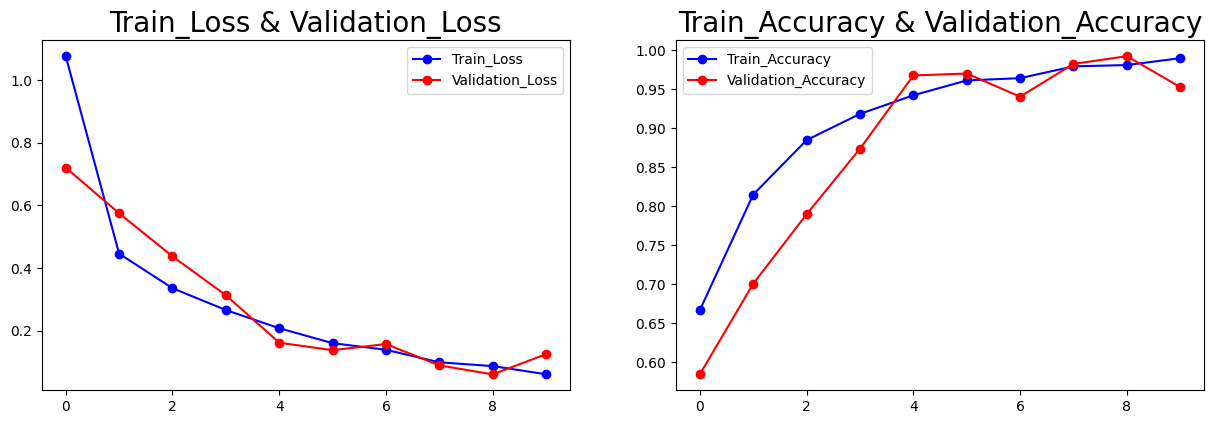

In [ ]:
# Access the training history correctly
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(fine_tuned_resnet_history.history['loss'],'b-o',label='Train_Loss') # Use history.history to access the metrics
plt.plot(fine_tuned_resnet_history.history['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(fine_tuned_resnet_history.history['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(fine_tuned_resnet_history.history['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
# Check if 'specificity_at_sensitivity' and 'auc' are available in your history
if 'specificity_at_sensitivity' in history.history:
    plt.subplot(2,2,3)
    plt.plot(fine_tuned_resnet_history.history['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
    plt.plot(fine_tuned_resnet_history.history['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
    plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
    plt.legend()
if 'auc' in fine_tuned_resnet_history.history:
    plt.subplot(2,2,4)
    plt.plot(fine_tuned_resnet_history.history['auc'],'b-o',label='Train_auc')
    plt.plot(fine_tuned_resnet_history.history['val_auc'],'r-o',label='Validation_auc')
    plt.title('Train_AUC & Validation_AUC',fontsize=20)
    plt.legend()
plt.show()